<a href="https://colab.research.google.com/github/AnahVeronica/RANZCR_CLiP_Catheter_and_Line_Position_Challenge/blob/main/RANZCR_CLiP_Catheter_and_Line_Position_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary files

In [1035]:
#Mount drive to access train and test tfrecords

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1036]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import io
from PIL import Image
import tensorflow as tf
from IPython import display
import cv2 as cv

In [1037]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD


# Step 1: Get dataset from directory

In [1082]:
Train_folder_path = '/content/drive/MyDrive/train_tfrecords'

In [1083]:
TFRecord_filenames = []

In [1084]:
for dirpath, dirnames, files in os.walk(Train_folder_path):
  for filename in files:
    TFRecord_filenames.append(os.path.join(dirpath, filename))



In [1085]:
dataset_size = 30083

train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

# Create a training and a validation datasets
full_dataset = tf.data.TFRecordDataset(TFRecord_filenames)
full_dataset = full_dataset.shuffle(buffer_size=1000)
train_dataset = full_dataset.take(train_size) #.cache()
val_dataset = full_dataset.skip(train_size).take(val_size)

#Step 2:Write functions to parse tfrecord

In [1086]:
feature_dictionary = {
    'CVC - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'CVC - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'CVC - Normal': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'ETT - Normal': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Abnormal': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Borderline': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Incompletely Imaged': tf.io.FixedLenFeature([], tf.int64),
    'NGT - Normal': tf.io.FixedLenFeature([], tf.int64),
    'StudyInstanceUID': tf.io.FixedLenFeature([], tf.string),    
    'Swan Ganz Catheter Present': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
}

In [1087]:
target_size_dim = 300
# Define two parsing functions that will turn the TFRecord back into an array and a label        
def _parse_function(example, feature_dictionary=feature_dictionary):
    # Parse the input `tf.train.Example` proto using the feature_dictionary.
    # Create a description of the features.
    parsed_example = tf.io.parse_example(example, feature_dictionary)

    CVC_Abnormal = tf.cast(parsed_example['CVC - Abnormal'], tf.int64)
    CVC_Borderline = tf.cast(parsed_example['CVC - Borderline'], tf.int64)
    CVC_Normal = tf.cast(parsed_example['CVC - Normal'], tf.int64)
    ETT_Abnormal = tf.cast(parsed_example['ETT - Abnormal'], tf.int64)
    ETT_Borderline = tf.cast(parsed_example['ETT - Borderline'], tf.int64)
    ETT_Normal = tf.cast(parsed_example['ETT - Normal'], tf.int64)
    NGT_Abnormal = tf.cast(parsed_example['NGT - Abnormal'], tf.int64)
    NGT_Borderline = tf.cast(parsed_example['NGT - Borderline'], tf.int64)
    NGT_Incompletely_Imaged = tf.cast(parsed_example['NGT - Incompletely Imaged'], tf.int64)
    NGT_Normal = tf.cast(parsed_example['NGT - Normal'], tf.int64)
    #Image = tf.cast(parsed_example['image'], tf.string)


    features =  tf.io.decode_image(parsed_example['image'], expand_animations = False)
    features =  tf.image.grayscale_to_rgb(features)
    features =  tf.image.resize(features,size=(target_size_dim, target_size_dim))
    #features = features/255
    #features = features - tf.math.reduce_mean(features, axis= 0)

    labels = [CVC_Abnormal, CVC_Borderline, CVC_Normal, ETT_Abnormal, ETT_Borderline, ETT_Normal, NGT_Abnormal, NGT_Borderline, NGT_Incompletely_Imaged, NGT_Normal]
    return features, labels



In [1088]:


def _clahe_preprocess(image, labels):
  clahe = cv.createCLAHE(clipLimit=15.0, tileGridSize=(8,8))
  img = image.numpy()
  img = np.uint8(img)
  lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
  lab_planes = cv.split(lab)
  lab_planes[0] = clahe.apply(lab_planes[0])
  lab = cv.merge(lab_planes)
  img = cv.cvtColor(lab, cv.COLOR_LAB2BGR)

  img = img/255
  img -= np.mean(img)
  return img, labels

#Step 3: Create a data loader

In [1089]:
def data_loader(train_data):
  dataset = train_data.map(_parse_function)
  dataset = dataset.map(lambda image,label: tf.py_function(func=_clahe_preprocess,
                                                      inp=[image,label],
                                                      Tout=[np.float32,tf.int64]))
  return dataset

# Load data and view image

In [1090]:
def get_dataset(filenames):
    dataset = data_loader(filenames)
    return dataset

In [1091]:

train_dataset = get_dataset(train_dataset)

In [1092]:
inspect = list(train_dataset.take(1).as_numpy_iterator())

In [1093]:
inspect[0][0].shape

(300, 300, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


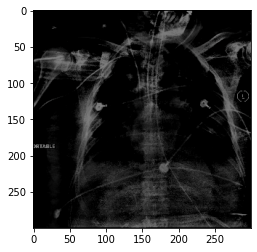

In [1094]:
plt.imshow(inspect[0][0].squeeze())